In [2]:
#!pip install scikit-plot

In [3]:
import numpy as np
import pandas as pd
from keras import backend as K
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from collections import defaultdict
from yellowbrick.contrib.classifier import DecisionViz
from sklearn.decomposition import PCA
from itertools import product
from yellowbrick.datasets import load_credit
from yellowbrick.features import PCA as yPCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score 
from scikitplot.metrics import plot_precision_recall, plot_roc, plot_cumulative_gain, plot_lift_curve
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import KFold
from sklearn import tree
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, classification_report

funzioni utili

In [4]:
def result_pred(y_true, y_pred):
    print("**** Matrice di Confusione *****")
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(' True negative: %d False negative: %d' % (tn, fn))
    print(' True positive: %d False positive: %d' % (tp, fp))
    print("____________________________________________")

    # Calcolo dell'accuracy
    print("***** Calcolo dell'accuracy *****")
    accuracy = accuracy_score(y_true, y_pred)    
    print('Frazione di campioni correttamente correlati: %0.4f' % accuracy)
    accuracy = accuracy_score(y_true, y_pred, False)
    print("Numero di campioni correttamente correlati: ", accuracy)    
    print("____________________________________________")

    # Calcolo della precision
    print("**** Calcolo della precisione *****")
    #Percentuale di classificazioni positive che sono corrette
    #se dico "positivo" dico giusto?
    precision = precision_score(y_true, y_pred)
    print('Percentuale di classificazioni positive che sono corrette: %0.4f' % precision)   
    print("____________________________________________")    

    # Calcolo della recall
    print("**** Calcolo della recall (sensitivity) *****")
    recall = recall_score(y_true, y_pred)
    print('Percentuale di elementi positivi del testing set che sono stati classificati come positivi: %0.4f' % recall)
    print("____________________________________________")    

    # Calcolo della specificity
    print("**** Calcolo della specificity *****")
    specificity = tn / (tn+fp)
    print('Percentuale di elementi negativi del testing set che sono stati classificati come negativi: %0.4f' % specificity)
    print("____________________________________________")   
    
    # Calcolo dell'F1 score
    print("**** Calcolo della F1 score *****")
    f1 = f1_score(y_true, y_pred)
    #Il punteggio F1 può essere interpretato come una media ponderata della precisione e della recall, 
    #in cui un punteggio F1 raggiunge il suo valore migliore a 1 e il punteggio peggiore a 0.
    print('F1 scores: %0.4f' % f1)
    print("____________________________________________")   
    
    # Stampiamo le stesse statistiche dalla funzione report
    print(classification_report(y_test, y_pred))
    
    print("Con le tecniche viste finora non viene fornita nessuna informazione sulla “gravità” degli errori (“errore lieve” oppure “errore grave)")
    print("per questo si usano la curva CMC, la curva ROC")

In [5]:
def plot_res(y_pred, y_score, y_test):
    #ROC CURVE: implementazione legata esclusivamente all'attività di classificazione binaria
    #false positive rate, true positive rate
    print("****** ROC CURVE + AUC?: passo passo *******")
    fprate, tprate, threashold = roc_curve(y_test, y_score[:, 1])
    auc_score = auc(fprate, tprate)
    plt.plot(fprate, tprate, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (auc_score))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC curve', fontsize=16)
    plt.legend(loc="lower right", fontsize=14, frameon=False)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.show()

    print("____________________________________")
    print("****** VALORE DI AUC *******")    
    print(roc_auc_score(y_test, y_score[:,1]))    
    
    print("____________________________________")
    print("****** ROC CURVE: con metodo diretto *******")
    plot_roc(y_test, y_score)
    plt.show()
    
    print("____________________________________")
    print("****** Precision recall: con metodo diretto *******")
    plot_precision_recall(y_test, y_score)
    plt.show()
    

    print("____________________________________")
    print("****** Cumulative gain: con metodo diretto *******")
    plot_cumulative_gain(y_test, y_score)
    plt.show()
    
    
    print("____________________________________")
    print("****** Lift curve: con metodo diretto *******")    
    plot_lift_curve(y_test, y_score)
    plt.show()

In [6]:
def f1(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    
    return 2*((prec*rec)/(prec+rec+K.epsilon()))
def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

datasets 

In [7]:
df_train = pd.read_csv("/content/Train_NOoutliers")
df_train = df_train.drop(columns=['Unnamed: 0'], axis = 1)
df_train = df_train.drop(columns=['outlier_detection'], axis = 1)
df_test = pd.read_csv("/content/Test_ripulito")
df_test = df_test.drop(columns=['Unnamed: 0'], axis = 1)

In [8]:
df_train_final = df_train[(df_train.emotion != "neutral") & (df_train.emotion != "surprised")]
df_test_final = df_test[(df_test.emotion != "neutral") & (df_test.emotion != "surprised")]

In [9]:
train_positive = []
for value in df_train_final['emotion']:
  if((value == 'happy') | (value == 'calm')):
    train_positive.append(1)
  else:
    train_positive.append(0)

In [10]:
test_positive = []
for value in df_test_final['emotion']:
  if((value == 'happy') | (value == 'calm')):
    test_positive.append(1)
  else:
    test_positive.append(0)

In [11]:
df_train_final = df_train_final.assign(positive = train_positive)
df_test_final = df_test_final.assign(positive = test_positive)
#1 se emozioni positive 
#0 se emozioni negative
#neutral e surprised NON incluse

In [14]:
X_train = df_train_final.drop(columns=['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'sex', 'filename','positive'], axis = 1)
y_train = df_train_final[['positive']]
X_test = df_test_final.drop(columns=['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'sex', 'filename','positive'], axis = 1)
y_test = df_test_final[['positive']]

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [16]:
# make sure data are np.ndarray
y_train = np.array(y_train)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

DEEP NEURAL NETWORK

In [45]:
from keras.models import Sequential
from keras.layers import Dense
#from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD
from sklearn.model_selection import GridSearchCV

In [32]:
n_classes = 2
def build_model():
    
    n_feature = X_train.shape[1]
    model = Sequential()
    model.add(Dense(128, input_dim=n_feature, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer="adam", metrics=['accuracy'])
    return model

In [33]:
model1 = build_model()
model1.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_249 (Dense)           (None, 128)               25344     
                                                                 
 dense_250 (Dense)           (None, 64)                8256      
                                                                 
 dense_251 (Dense)           (None, 2)                 130       
                                                                 
Total params: 33,730
Trainable params: 33,730
Non-trainable params: 0
_________________________________________________________________


In [34]:
history1 = model1.fit(X_train, y_train, epochs=200, batch_size=32).history

Epoch 1/200
48/48 [==============================] - 1s 3ms/step - loss: 0.6353 - accuracy: 0.6488
Epoch 2/200
48/48 [==============================] - 0s 3ms/step - loss: 0.4721 - accuracy: 0.7739
Epoch 3/200
48/48 [==============================] - 0s 3ms/step - loss: 0.3970 - accuracy: 0.8244
Epoch 4/200
48/48 [==============================] - 0s 3ms/step - loss: 0.3343 - accuracy: 0.8624
Epoch 5/200
48/48 [==============================] - 0s 3ms/step - loss: 0.2909 - accuracy: 0.8879
Epoch 6/200
48/48 [==============================] - 0s 3ms/step - loss: 0.2488 - accuracy: 0.9201
Epoch 7/200
48/48 [==============================] - 0s 3ms/step - loss: 0.1965 - accuracy: 0.9391
Epoch 8/200
48/48 [==============================] - 0s 3ms/step - loss: 0.1598 - accuracy: 0.9522
Epoch 9/200
48/48 [==============================] - 0s 3ms/step - loss: 0.1331 - accuracy: 0.9620
Epoch 10/200
48/48 [==============================] - 0s 3ms/step - loss: 0.1100 - accuracy: 0.9744
Epoch 11/

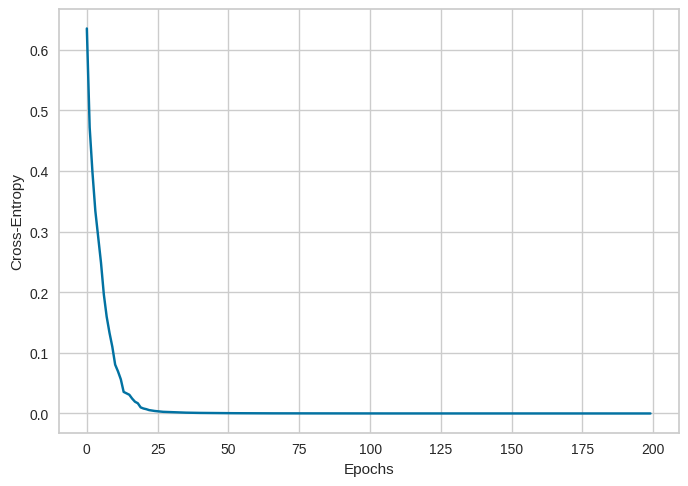

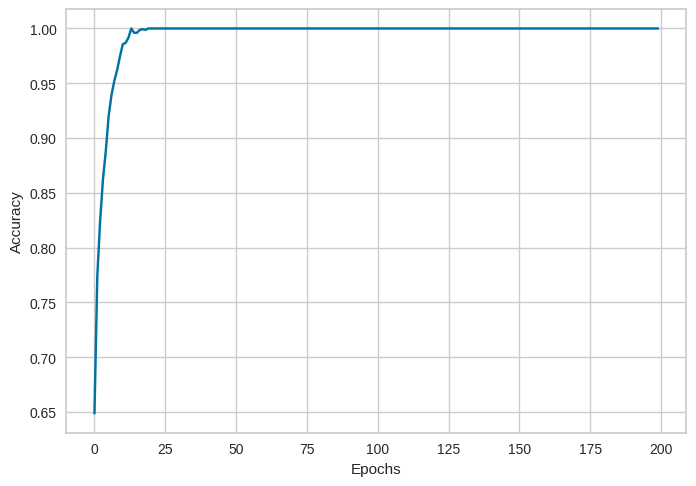

In [35]:
plt.plot(history1['loss'])
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.show()
plt.plot(history1['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [36]:
test_loss_1, test_acc_1 = model1.evaluate(X_test, y_test)
print('Loss %f, Accuracy %f' % (test_loss_1, test_acc_1))

17/17 [==============================] - 0s 2ms/step - loss: 3.7536 - accuracy: 0.6932
Loss 3.753616, Accuracy 0.693182


In [43]:
!pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [46]:
from scikeras.wrappers import KerasClassifier

In [47]:
clf = KerasClassifier(build_fn=build_model)

In [48]:
clf.fit(X_train, y_train, epochs=200)

/usr/local/lib/python3.9/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/200
48/48 [==============================] - 1s 3ms/step - loss: 0.6257 - accuracy: 0.6481
Epoch 2/200
48/48 [==============================] - 0s 3ms/step - loss: 0.4721 - accuracy: 0.7720
Epoch 3/200
48/48 [==============================] - 0s 2ms/step - loss: 0.3918 - accuracy: 0.8316
Epoch 4/200
48/48 [==============================] - 0s 3ms/step - loss: 0.3361 - accuracy: 0.8650
Epoch 5/200
48/48 [==============================] - 0s 3ms/step - loss: 0.2811 - accuracy: 0.8866
Epoch 6/200
48/48 [==============================] - 0s 3ms/step - loss: 0.2262 - accuracy: 0.9214
Epoch 7/200
48/48 [==============================] - 0s 3ms/step - loss: 0.2022 - accuracy: 0.9312
Epoch 8/200
48/48 [==============================] - 0s 3ms/step - loss: 0.1537 - accuracy: 0.9541
Epoch 9/200
48/48 [==============================] - 0s 3ms/step - loss: 0.1275 - accuracy: 0.9640
Epoch 10/200
48/48 [==============================] - 0s 3ms/step - loss: 0.1041 - accuracy: 0.9758
Epoch 11/

KerasClassifier(
	model=None
	build_fn=<function build_model at 0x7f06a7ff6790>
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
	class_weight=None
)

In [49]:
clf.model_.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_255 (Dense)           (None, 128)               25344     
                                                                 
 dense_256 (Dense)           (None, 64)                8256      
                                                                 
 dense_257 (Dense)           (None, 2)                 130       
                                                                 
Total params: 33,730
Trainable params: 33,730
Non-trainable params: 0
_________________________________________________________________


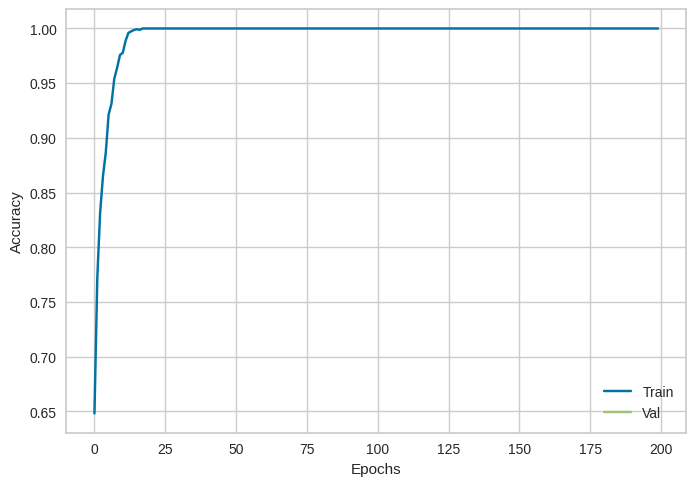

In [50]:
history = clf.history_
plt.plot(history['accuracy'], label='Train')
plt.plot(history['val_accuracy'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

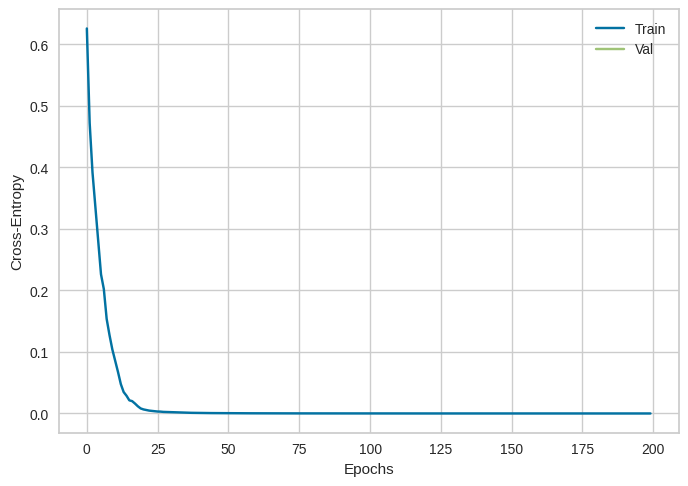

In [51]:
plt.plot(history['loss'], label='Train')
plt.plot(history['val_loss'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

In [52]:
y_pred = clf.predict(X_test).astype(int)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

17/17 [==============================] - 0s 2ms/step
Accuracy 0.6893939393939394
F1-score [0.75075988 0.5879397 ]
              precision    recall  f1-score   support

           0       0.77      0.74      0.75       336
           1       0.57      0.61      0.59       192

    accuracy                           0.69       528
   macro avg       0.67      0.67      0.67       528
weighted avg       0.69      0.69      0.69       528



In [53]:
clf = KerasClassifier(build_fn=build_model)

In [54]:
clf.fit(X_train, y_train, validation_split=0.2, epochs=1000)

Epoch 1/1000


/usr/local/lib/python3.9/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


39/39 [==============================] - 2s 14ms/step - loss: 0.6461 - accuracy: 0.6328 - val_loss: 0.6592 - val_accuracy: 0.6242
Epoch 2/1000
39/39 [==============================] - 0s 6ms/step - loss: 0.4750 - accuracy: 0.7746 - val_loss: 0.7004 - val_accuracy: 0.6275
Epoch 3/1000
39/39 [==============================] - 0s 4ms/step - loss: 0.3974 - accuracy: 0.8262 - val_loss: 0.7454 - val_accuracy: 0.6340
Epoch 4/1000
39/39 [==============================] - 0s 4ms/step - loss: 0.3353 - accuracy: 0.8574 - val_loss: 0.8385 - val_accuracy: 0.6340
Epoch 5/1000
39/39 [==============================] - 0s 4ms/step - loss: 0.2802 - accuracy: 0.8967 - val_loss: 0.7829 - val_accuracy: 0.6405
Epoch 6/1000
39/39 [==============================] - 0s 4ms/step - loss: 0.2234 - accuracy: 0.9303 - val_loss: 0.9825 - val_accuracy: 0.6275
Epoch 7/1000
39/39 [==============================] - 0s 4ms/step - loss: 0.1886 - accuracy: 0.9475 - val_loss: 0.9838 - val_accuracy: 0.6275
Epoch 8/1000
39/39

KerasClassifier(
	model=None
	build_fn=<function build_model at 0x7f06a7ff6790>
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
	class_weight=None
)

In [55]:
y_pred = clf.predict(X_test).astype(int)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

17/17 [==============================] - 0s 2ms/step
Accuracy 0.6931818181818182
F1-score [0.75076923 0.60098522]
              precision    recall  f1-score   support

           0       0.78      0.73      0.75       336
           1       0.57      0.64      0.60       192

    accuracy                           0.69       528
   macro avg       0.67      0.68      0.68       528
weighted avg       0.70      0.69      0.70       528



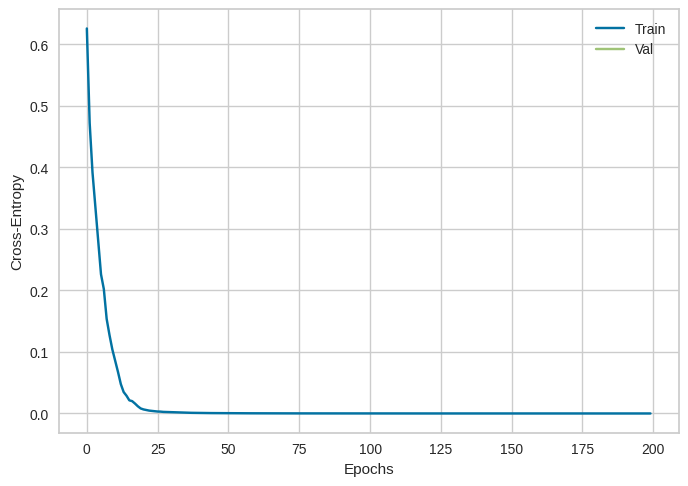

In [56]:
plt.plot(history['loss'], label='Train')
plt.plot(history['val_loss'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

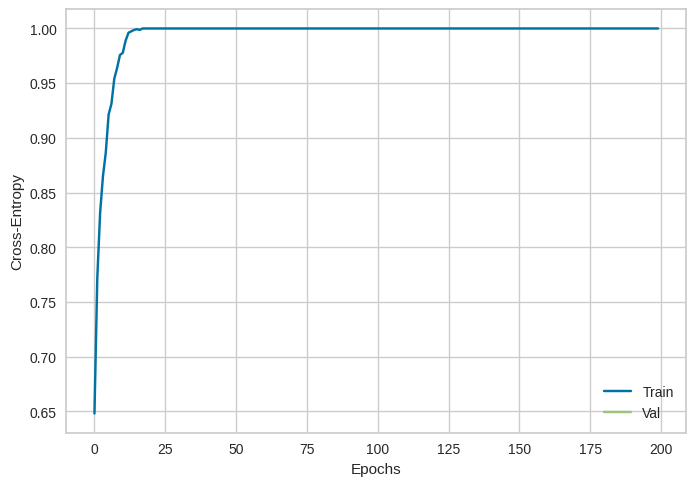

In [57]:
plt.plot(history['accuracy'], label='Train')
plt.plot(history['val_accuracy'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

early stopping

In [58]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

The most relevant arguments are:

* monitor: quantity to be monitored
* patience: number of epochs with no improvement after which training will be stopped

In [59]:
es = EarlyStopping(monitor='val_accuracy', patience=50, verbose=True)
mc = ModelCheckpoint('best_model_NOREG.h5', monitor='val_accuracy', save_best_only=True)

clf = KerasClassifier(build_model, callbacks=[es, mc])

In [60]:
clf.fit(X_train, y_train, validation_split=0.2, epochs=500)

Epoch 1/500
39/39 [==============================] - 1s 10ms/step - loss: 0.6052 - accuracy: 0.6557 - val_loss: 0.6040 - val_accuracy: 0.6699
Epoch 2/500
39/39 [==============================] - 0s 5ms/step - loss: 0.4444 - accuracy: 0.7918 - val_loss: 0.6415 - val_accuracy: 0.6471
Epoch 3/500
39/39 [==============================] - 0s 6ms/step - loss: 0.3722 - accuracy: 0.8361 - val_loss: 0.6596 - val_accuracy: 0.6797
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 0.3120 - accuracy: 0.8730 - val_loss: 0.7589 - val_accuracy: 0.6275
Epoch 5/500
39/39 [==============================] - 0s 4ms/step - loss: 0.2584 - accuracy: 0.9139 - val_loss: 0.7796 - val_accuracy: 0.6569
Epoch 6/500
39/39 [==============================] - 0s 5ms/step - loss: 0.2337 - accuracy: 0.9090 - val_loss: 0.7950 - val_accuracy: 0.6569
Epoch 7/500
39/39 [==============================] - 0s 4ms/step - loss: 0.1941 - accuracy: 0.9344 - val_loss: 0.9020 - val_accuracy: 0.6307
Epoch 8/500


KerasClassifier(
	model=<function build_model at 0x7f06a7ff6790>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=[<keras.callbacks.EarlyStopping object at 0x7f06b6678910>, <keras.callbacks.ModelCheckpoint object at 0x7f06b6678070>]
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
	class_weight=None
)

In [61]:
y_pred = clf.predict(X_test).astype(int)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

17/17 [==============================] - 0s 4ms/step
Accuracy 0.7102272727272727
F1-score [0.76853253 0.61265823]
              precision    recall  f1-score   support

           0       0.78      0.76      0.77       336
           1       0.60      0.63      0.61       192

    accuracy                           0.71       528
   macro avg       0.69      0.69      0.69       528
weighted avg       0.71      0.71      0.71       528



 L2 regularization

In [62]:
from keras.regularizers import l2, l1

def build_L2_model():
    model = Sequential()

    n_feature = X_train.shape[1]
    h_dim=100
    model.add(Dense(h_dim, activation='relu', 
                    input_shape=(n_feature,), kernel_regularizer=l2(0.001)))
    model.add(Dense(h_dim, activation='relu'))
    model.add(Dense(h_dim, activation='relu'))
    model.add(Dense(h_dim, activation='relu'))
    model.add(Dense(n_classes))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [63]:
mc = ModelCheckpoint('best_model_L2.h5', monitor='val_accuracy', save_best_only=True)

L2_model = KerasClassifier(build_L2_model, callbacks=[es,mc])
L2_model.fit(X_train, y_train, validation_split=0.2, epochs=500)

Epoch 1/500
39/39 [==============================] - 2s 12ms/step - loss: 0.9164 - accuracy: 0.3836 - val_loss: 0.8219 - val_accuracy: 0.3529
Epoch 2/500
39/39 [==============================] - 0s 5ms/step - loss: 0.8190 - accuracy: 0.3746 - val_loss: 0.8156 - val_accuracy: 0.3497
Epoch 3/500
39/39 [==============================] - 0s 5ms/step - loss: 0.8126 - accuracy: 0.3738 - val_loss: 0.8092 - val_accuracy: 0.3497
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 0.8062 - accuracy: 0.3738 - val_loss: 0.8030 - val_accuracy: 0.3497
Epoch 5/500
39/39 [==============================] - 0s 5ms/step - loss: 0.8001 - accuracy: 0.3730 - val_loss: 0.7970 - val_accuracy: 0.3497
Epoch 6/500
39/39 [==============================] - 0s 5ms/step - loss: 0.7942 - accuracy: 0.3705 - val_loss: 0.7912 - val_accuracy: 0.3497
Epoch 7/500
39/39 [==============================] - 0s 5ms/step - loss: 0.7886 - accuracy: 0.3697 - val_loss: 0.7857 - val_accuracy: 0.3529
Epoch 8/500


KerasClassifier(
	model=<function build_L2_model at 0x7f06a78bb280>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=[<keras.callbacks.EarlyStopping object at 0x7f06b6678910>, <keras.callbacks.ModelCheckpoint object at 0x7f06afbec700>]
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
	class_weight=None
)

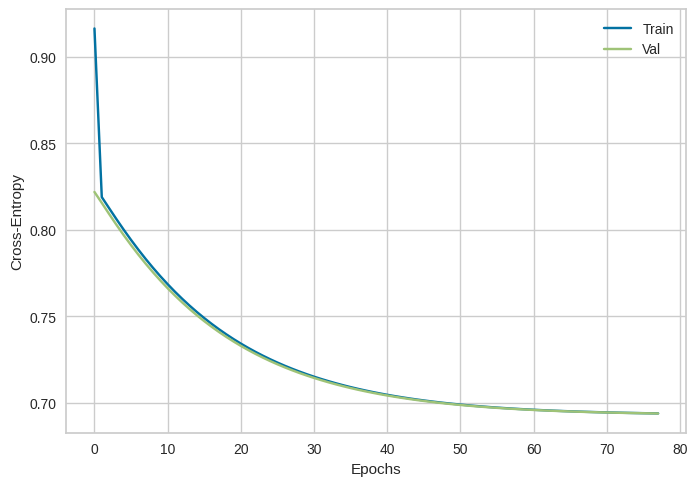

In [64]:
history = L2_model.history_
plt.plot(history['loss'], label='Train')
plt.plot(history['val_loss'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

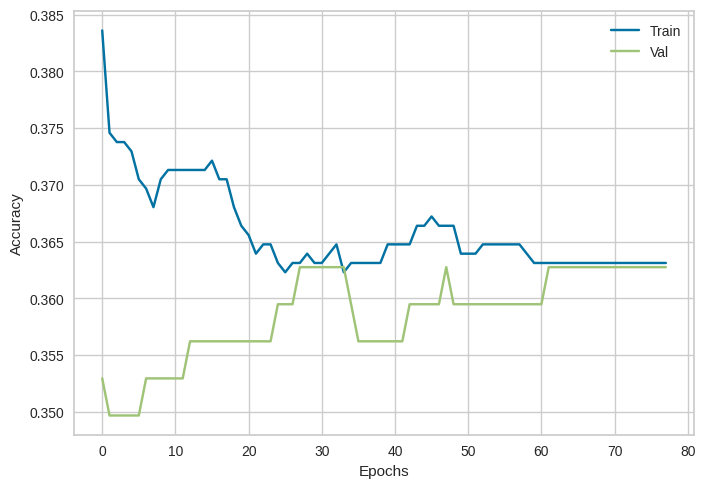

In [65]:
plt.plot(history['accuracy'], label='Train')
plt.plot(history['val_accuracy'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

  Dropout

In [66]:
from keras.layers import Dropout

def build_DROPOUT_model():
    # define the model
    model = Sequential()

    n_feature = X_train.shape[1]
    h_dim=100
    model.add(Dense(h_dim, activation='relu', input_shape=(n_feature,)))
    model.add(Dense(h_dim, activation='relu'))
    model.add(Dense(h_dim, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(h_dim, activation='relu'))
    #linear activation
    model.add(Dense(n_classes))

    #compile the model
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [67]:
mc = ModelCheckpoint('best_model_DROPOUT.h5', monitor='val_accuracy', save_best_only=True)

DROPOUT_model = KerasClassifier(build_DROPOUT_model, callbacks=[es,mc])
DROPOUT_model.fit(X_train, y_train, validation_split=0.2, epochs=500)

Epoch 1/500
39/39 [==============================] - 2s 12ms/step - loss: 0.9122 - accuracy: 0.5844 - val_loss: 0.6931 - val_accuracy: 0.6176
Epoch 2/500
39/39 [==============================] - 0s 6ms/step - loss: 0.6931 - accuracy: 0.5746 - val_loss: 0.6931 - val_accuracy: 0.6242
Epoch 3/500
39/39 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.5877 - val_loss: 0.6931 - val_accuracy: 0.6242
Epoch 4/500
39/39 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.5795 - val_loss: 0.6931 - val_accuracy: 0.6242
Epoch 5/500
39/39 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.5680 - val_loss: 0.6931 - val_accuracy: 0.6242
Epoch 6/500
39/39 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.5893 - val_loss: 0.6931 - val_accuracy: 0.6242
Epoch 7/500
39/39 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.5598 - val_loss: 0.6931 - val_accuracy: 0.6242
Epoch 8/500


KerasClassifier(
	model=<function build_DROPOUT_model at 0x7f06af4325e0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=[<keras.callbacks.EarlyStopping object at 0x7f06b6678910>, <keras.callbacks.ModelCheckpoint object at 0x7f06ac31ea00>]
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
	class_weight=None
)

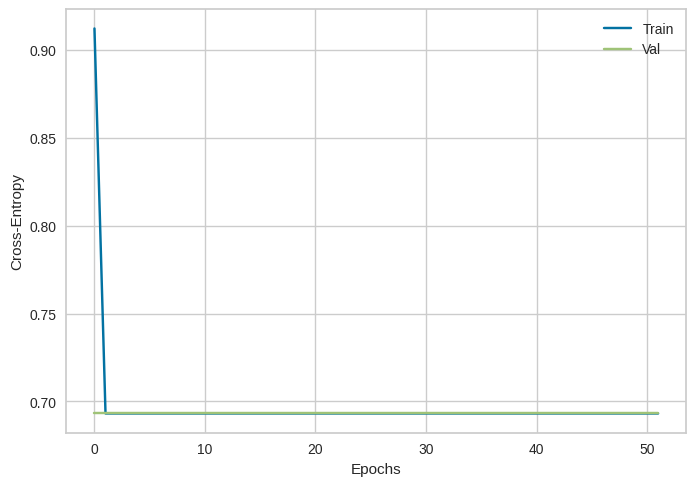

In [68]:
history = DROPOUT_model.history_
plt.plot(history['loss'], label='Train')
plt.plot(history['val_loss'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

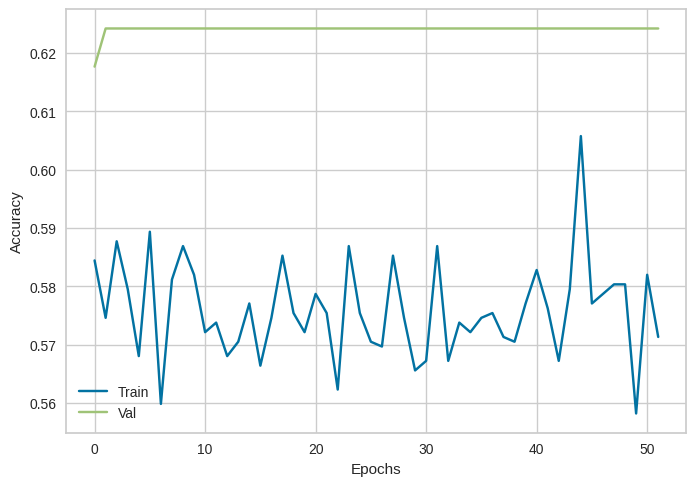

In [69]:
plt.plot(history['accuracy'], label='Train')
plt.plot(history['val_accuracy'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

model comparison

In [70]:
# laod best models and test them
from keras.models import load_model

best_NOREG_model = load_model('best_model_NOREG.h5')
best_L2_model = load_model('best_model_L2.h5')
best_DROPOUT_model = load_model('best_model_DROPOUT.h5')

loss_NOREG, acc_NOREG = best_NOREG_model.evaluate(X_test, y_test)
loss_L2, acc_L2 = best_L2_model.evaluate(X_test, y_test)
loss_DROPOUT, acc_DROPOUT = best_DROPOUT_model.evaluate(X_test, y_test)

17/17 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.6023


In [71]:
print('Loss %f, Accuracy %f' % (loss_NOREG, acc_NOREG))
print('Loss %f, Accuracy %f' % (loss_L2, acc_L2))
print('Loss %f, Accuracy %f' % (loss_DROPOUT, acc_DROPOUT))

Loss 0.699953, Accuracy 0.679924
Loss 0.718882, Accuracy 0.371212
Loss 0.693147, Accuracy 0.602273


hyper parameter tuning 

In [103]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense

In [104]:
def build_model(meta, hidden_layer_sizes, activation):
    n_features_in_ = meta["n_features_in_"]
    n_classes_ = meta["n_classes_"]
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=(n_features_in_,)))
    for hidden_layer_size in hidden_layer_sizes:
        model.add(keras.layers.Dense(hidden_layer_size, activation=activation))
    model.add(keras.layers.Dense(n_classes_, activation="softmax"))
    return model

In [105]:
clf = KerasClassifier(model=build_model,loss="sparse_categorical_crossentropy",verbose=False)

In [106]:
params = {
    'optimizer__learning_rate': [0.001, 0.01, 0.1, 1],
    'model__hidden_layer_sizes': [(100, 100, 100), (50, 50, 50), (10, 10, 10), (100, 50, 10)],
    'model__activation': ['relu', 'tanh'],
    'optimizer': ["adam", "sgd"],
    'epochs': [10, 50, 100, 200, 500]
}
gs = RandomizedSearchCV(clf, params, scoring = 'accuracy', n_jobs=-1, verbose=True, n_iter=20, cv=3)

In [107]:
gs.fit(X_train, y_train)
print(gs.best_score_, gs.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
0.658577365943206 {'optimizer__learning_rate': 0.01, 'optimizer': 'sgd', 'model__hidden_layer_sizes': (100, 100, 100), 'model__activation': 'relu', 'epochs': 50}


In [110]:
clf = KerasClassifier(model=build_model,loss="sparse_categorical_crossentropy",verbose=False, optimizer__learning_rate= 0.01, optimizer = 'sgd', model__hidden_layer_sizes=(100, 100, 100), model__activation= 'relu', epochs= 50)

In [113]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test).astype(int)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.7083333333333334
F1-score [0.76807229 0.60714286]
              precision    recall  f1-score   support

           0       0.78      0.76      0.77       336
           1       0.59      0.62      0.61       192

    accuracy                           0.71       528
   macro avg       0.69      0.69      0.69       528
weighted avg       0.71      0.71      0.71       528

